In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration, io, img_as_float
from skimage.restoration import uft
from scipy.signal import fftconvolve, convolve, convolve2d

In [2]:
# Prepare data
sz = 11
astro = color.rgb2gray(data.astronaut())

psf = np.ones((sz, sz)) / (sz*sz)
astro_noisy = conv2(astro, psf, 'same')
# Add Noise to Image
#astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

In [3]:
def show_results(original, noisy, result):
    # Show results
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
    plt.gray()

    for a in (ax[0], ax[1], ax[2]):
           a.axis('off')

    ax[0].imshow(original)
    ax[0].set_title('Original Data')

    ax[1].imshow(noisy)
    ax[1].set_title('Blurred data')

    ax[2].imshow(result, vmin=noisy.min(), vmax=noisy.max())
    ax[2].set_title('Restoration using\nRichardson-Lucy')


    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                        top=0.9, bottom=0.05, left=0, right=1)
    plt.show()

In [15]:
def desubsample(image, times=1, axises=None):
    if axises is None:
        axises = [i for i, sz in enumerate(image.shape) if sz > 4]
    for axis in axises:
        image = image.repeat(times, axis)#, inplace=True)
    return image

def corelucy(Y, psf, dampar22, wI, readout, subsample, numNSdim, vec, num, eps=1e-9):
    """
    CORELUCY Accelerated Damped Lucy-Richarson Operator.
    Calculates function that when used with the scaled projected array
    produces the next iteration array that maximizes the likelihood that
    the entire suite satisfies the Poisson statistics.
    """
    #reBlurred = np.real(np.fft.ifftn(H * np.fft.fftn(Y)))
    reBlurred = np.real(convolve2d(Y, psf, 'same'))

    # 1. Resampling if needed
    if subsample != 1: # Bin reBlurred back to the sizeI for non-singleton dims
        #1.Reshape so that the-to-binned dimension separates into two
        #dimensions, with one of them consisting of elements of a single bin.
        reBlurred = np.reshape(reBlurred, vec);

        #2. Bin (==calculate mean) along the first of the-to-binned dimension,
        #that dimension consists of the bin elements. Reshape to get rid off
        for k in num: # new appeared singleton.
            vec.pop(k) #~ vec(k) = [];
            reBlurred = reshape(mean(reBlurred,k),vec);

    # 2. An Estimate for the next step
    reBlurred += readout;
    reBlurred[reBlurred == 0] = eps;
    AnEstim = wI / reBlurred + eps;

    # 3. Damping if needed
    if dampar22 == 0: # No Damping
        ImRatio = desubsample(AnEstim, subsample, numNSdim);
    else: # Damping of the image relative to dampar22 = (N*sigma)^2
        gm = 10;
        g = (wI * np.log(AnEstim)+ reBlurred - wI) / dampar22;
        g = np.minimum(g,1);
        G = (g**(gm-1))*(gm-(gm-1)*g);
        ImRatio = 1 + desubsample(G,subsample, numNSdim) * (desubsample(AnEstim0, subsample, numNSdim) - 1);

    #return np.fft.fftn(ImRatio);
    return ImRatio

def richardson_lucy_matlab(image, psf, iterations=50, damp_array=0, weight=None, readout=0, subsample=1, eps=1e-16, clip=True):
    """ Richardson-Lucy deconvolution.

    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function.
    iterations : int
       Number of iterations. This parameter plays the role of
       regularisation.
    """
    #if 'eps' not in globals():
    #    eps = 1e-9
    # to continue restoration
    sizeI = image.shape
    sizePSF = psf.shape
    numNSdim = [i for i, sz in enumerate(sizePSF) if sz > 4] # do not desubsample rgb axis

    assert(not np.all(psf == 0))

    if isinstance(image, list) and len(image) == 4:
        image, prev_image, prev_prev_image, internal = image
    else:
        prev_image = np.ones(image.shape)*.5#image
        prev_prev_image = 0
        internal = np.zeros((image.size*subsample**len(numNSdim),2))
    internal[:,1] = 0

    if weight is None:
        weight = np.ones(image.shape)

    # 1. Prepare OTF
    #~ H = psf2otf(psf, sizeI);
    if psf.shape != image.shape:
        H = uft.ir2tf(psf, image.shape, is_real=False)
    else:
        H = psf

    wI = np.maximum(weight * (readout + image), 0)
    prev_image = desubsample(prev_image, subsample, numNSdim)
    #scale = np.real(np.fft.ifftn(np.conj(H)*np.fft.fftn(desubsample(weight)))) + np.sqrt(eps)
    scale = np.real(convolve2d(desubsample(weight), psf, 'same')) + np.sqrt(eps)
    del weight

    dampar22 = np.square(damp_array)/2

    '''
    prepare vector of dimensions to facilitate the reshaping
    % when the matrix is binned within the iterations.
    '''
    vec = []
    num = []
    if subsample != 1:
        for dim, sz in enumerate(sizeI):
            if sz != 1:
                vec.extend((subsample, sz))
                num.append(dim)
            else:
                vec.append(sz)
    num.reverse()

    # 3 L_R Iterations
    lambd = 2 * np.any(internal != 0)
    correlation_X = []
    correlation_Y = []
    for k in range(lambd, lambd + iterations):

        # 3.a Make an image predictions for the next iteration
        if k > 2:
            lambd = (internal[:,0].T.dot(internal[:,1])) / (internal[:,1].T.dot(internal[:,1]) +eps) # (scalar division)
            lambd = max(min(lambd, 1), 0) # stability enforcement saturation
        Y = np.maximum(prev_image + lambd*(prev_image - prev_prev_image), 0) # plus positivity constraint

        # 3.b Make core for the LR estimation
        cc = corelucy(Y, psf, dampar22, wI, readout, subsample, numNSdim, vec, num, eps)

        # 3.c Determine next iteration image and apply poitivity constraint
        prev_prev_image = prev_image
        prev_image = np.maximum(Y * np.real(convolve2d(cc, psf, 'same')) / scale, 0)
        correlation_X.append(np.correlate(prev_image.ravel('C')[:-1], prev_image.ravel('C')[1:]))
        correlation_Y.append(np.correlate(prev_image.ravel('F')[:-1], prev_image.ravel('F')[1:]))
        del cc
        internal[:,1] = internal[:,0]
        internal[:,0] = (prev_image-Y).ravel()
    del wI, H, scale, Y
    if clip:
        prev_image[prev_image > 1] = 1
        prev_image[prev_image < -1] = -1
    return {'image': prev_image, 
            'correlationX': np.array(correlation_X)/(image.size-1), 
            'correlationY': np.array(correlation_Y)/(image.size-1)}

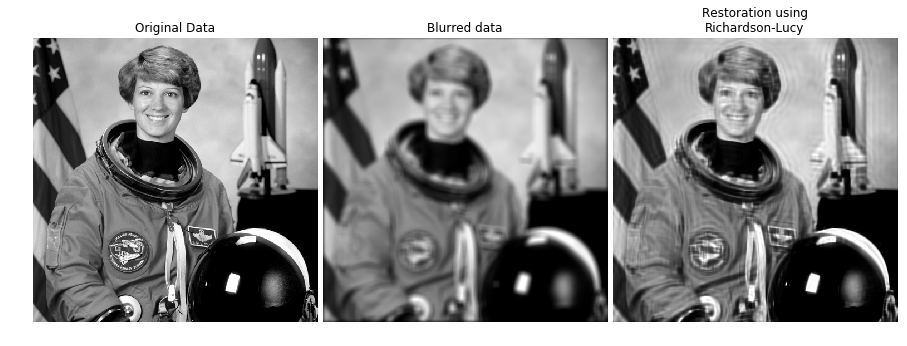

In [16]:
# Restore Image using Richardson-Lucy algorithm:
iterations = 20
deconv = richardson_lucy_matlab(astro_noisy, psf, iterations=iterations, eps=1e-5)
show_results(astro, astro_noisy, deconv['image'])

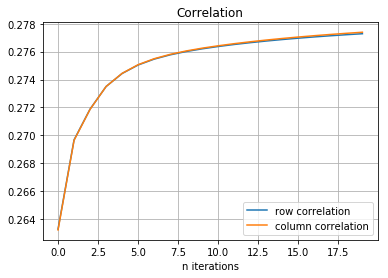

In [17]:
plt.plot(range(iterations), deconv['correlationX'],
         range(iterations), deconv['correlationY'])
plt.grid()
plt.title('Normalized correlation')
plt.xlabel('n iterations')
plt.legend(['row correlation', 'column correlation'])
plt.show()

In [18]:
liftingbody = img_as_float(io.imread('liftingbody.png'))
lifting_blurred = conv2(liftingbody, psf, 'same')

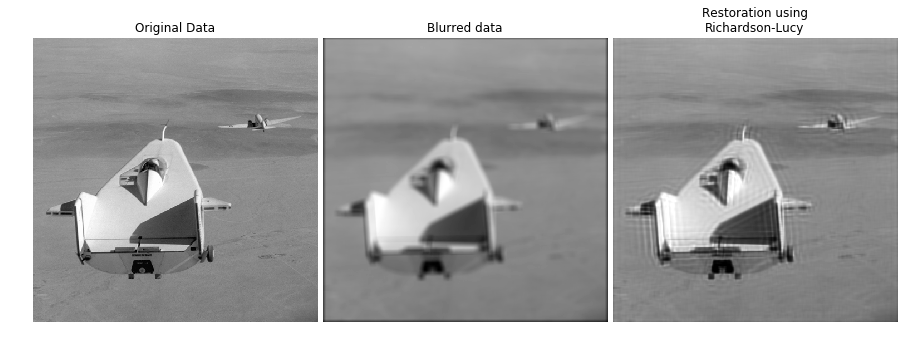

In [19]:
# Restore Image using Richardson-Lucy algorithm my:
iterations = 20
deconv = richardson_lucy_matlab(lifting_blurred, psf, iterations=iterations, eps=1e-5)
show_results(liftingbody, lifting_blurred, deconv['image'])

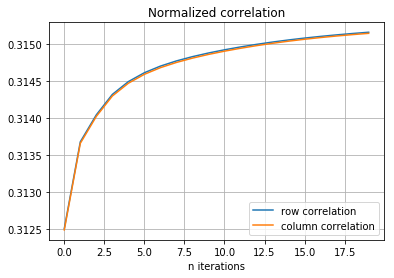

In [20]:
plt.plot(range(iterations), deconv['correlationX'],
         range(iterations), deconv['correlationY'])
plt.grid()
plt.title('Normalized correlation')
plt.xlabel('n iterations')
plt.legend(['row correlation', 'column correlation'])
plt.show()

In [44]:
def gen_psf():
    p0 = np.random.randint(6, 25)
    p1 = np.random.randint(6, 21)

    x = np.random.randint(0, p0, (1,4))#sort(randi([0 p0], 1, 4));
    y = np.random.randint(0, p1, (1,4))

    pt1 = [x[0]; y[0]]
    pt2 = [x[1]; y[1]]
    pt3 = [x[2]; y[2]]
    pt4 = [x[3]; y[3]]

    t = list(range(0, p0+1))
    pts = kron((1-t).^3,pt1) + kron(3*(1-t).^2.*t,pt2) + kron(3*(1-t).*t.^2,pt3) + kron(t.^3,pt4);
    x1 = 1:p0;
    y1 = round(pts(2, :));
    y1 = y1 - min(y1) + 1;
    %plot(x1,y1);
    pp = max(y1);
    PSF = zeros(p0, pp);

    for ind_x = 1:length(x1)
        yy = max(length(x1) - y1(ind_x), 1);
        PSF(yy, ind_x) = rand();
    end

    PSF = PSF./(sum(PSF(:)) + eps*p0*p0);

SyntaxError: invalid syntax (<ipython-input-44-a8d8a8cb361e>, line 8)

In [1]:
eps = 1e-16
p0 = np.random.randint(6, 25)
p1 = np.random.randint(6, 21)

x = np.random.randint(0, p0, 4)#sort(randi([0 p0], 1, 4));
y = np.random.randint(0, p1, 4)

pt1 = [x[0], y[0]]
pt2 = [x[1], y[1]]
pt3 = [x[2], y[2]]
pt4 = [x[3], y[3]]

t = np.array(range(0, p0+1))
pts = np.kron((1-t) ** 3, pt1) + np.kron(3*(1-t)**2 * t, pt2) + np.kron(3 * (1-t) * t**2, pt3) + np.kron(t**3, pt4)
x1 = np.arange(1, p0+1)
y1 = np.round(pts[:])
y1 = y1 - min(y1) + 1
#plot(x1,y1)
pp = np.max(y1)
PSF = np.zeros((p0, pp))

for ind_x in range(len(x1)):
    yy = max(len(x1) - y1[ind_x], 1)
    PSF[yy, ind_x] = np.random.rand()

PSF = PSF/(sum(PSF.ravel()) + eps*p0*p0)

NameError: name 'np' is not defined

In [46]:
PSF.shape

(12, 52305)

In [35]:
np.round(PSF, 2)

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.03, 0.08, 0.05, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])